In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

In [3]:
ticker = '^GSPC'
start = '2020-01-01'
end = '2021-07-10'

In [4]:
prices = yf.download(ticker, start, end)['Open']

[*********************100%***********************]  1 of 1 completed


In [5]:
#Divide array from 2nd to Last day by array from 1st to the penultimate date
returns = np.array(prices)[1:]/np.array(prices)[:-1] - 1

In [6]:
#Parameters
mean = np.average(returns)
var = np.std(returns)**2

In [7]:
def garch_mle(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    #long-run volatility
    long_run = (omega/(1- alpha - beta))**(1/2)
    
    #realized and conditional volatility
    resid = returns - mu
    realized = abs(resid)

    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    
    #log-likelihood
    likelihood = 1/((2*np.pi)**(1/2)*conditional) * np.exp(-realized**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [9]:
#maximize log-likelihood, minimize negative = maximize positive
res = spop.minimize(garch_mle, [mean, var, 0, 0], method='Nelder-Mead')

<ipython-input-7-682f1f78baf6>:17: RuntimeWarning: invalid value encountered in double_scalars
  conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
<ipython-input-7-682f1f78baf6>:8: RuntimeWarning: invalid value encountered in double_scalars
  long_run = (omega/(1- alpha - beta))**(1/2)


In [10]:
#retrieve optimal parameters
params = res.x
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]
log_likelihood = -float(res.fun)

In [11]:
#Calculating realized and conditional volatility (prev)
#long-run volatility
long_run = (omega/(1- alpha - beta))**(1/2)

#realized and conditional volatility
resid = returns - mu
realized = abs(resid)

conditional = np.zeros(len(returns))
conditional[0] = long_run
for t in range(1, len(returns)):
    conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)

In [14]:
#printing optimal params
print('GARCH Model Parameters')
print('')
print('mu: ' + str(round(mu,6)))
print('omega: ' + str(round(omega,6)))
print('alpha: ' + str(round(alpha,6)))
print('beta: ' + str(round(beta,6)))
print('long-run volatility: ' + str(round(long_run, 4)))
print('log-likelihood: ' + str(round(log_likelihood, 4)))

GARCH Model Parameters

mu: 0.000944
omega: 8e-06
alpha: 0.197763
beta: 0.743972
long-run volatility: 0.012
log-likelihood: 1185.46


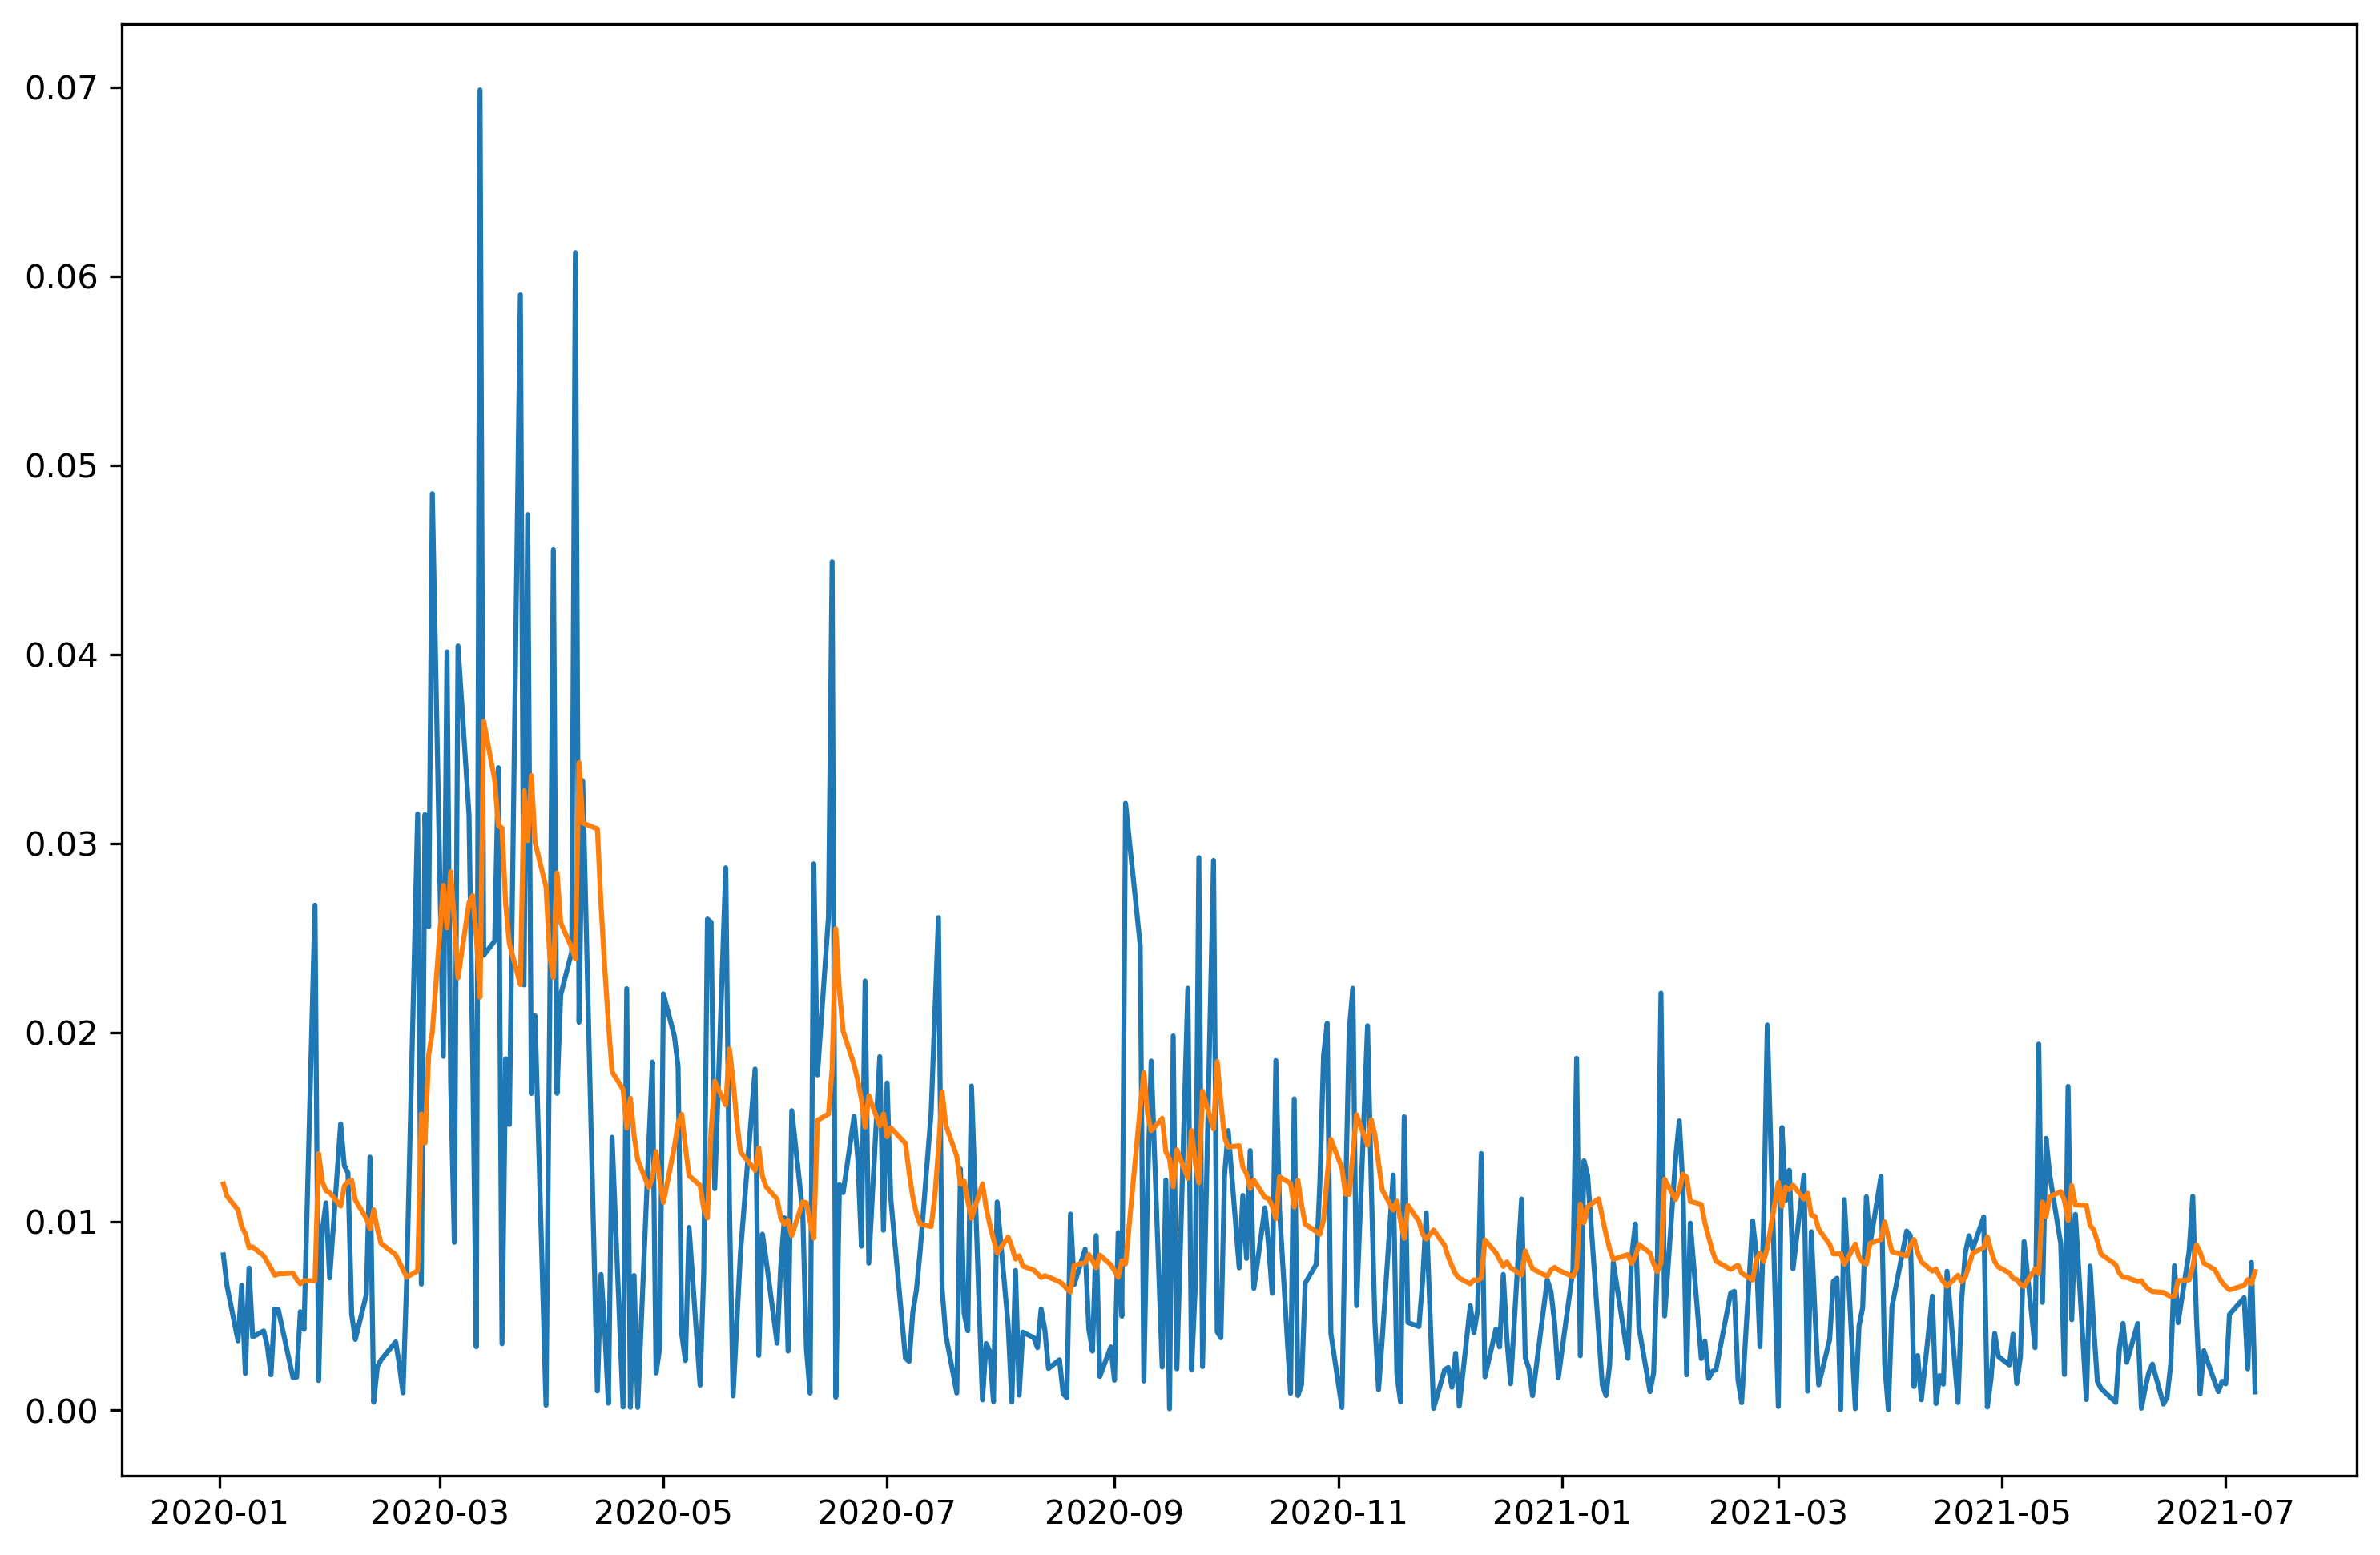

In [18]:
#visualization
fig=plt.figure(figsize=(12,8), dpi= 300, facecolor='w', edgecolor='k')
plt.figure(1)
plt.rc('xtick', labelsize = 10)
plt.plot(prices.index[1:], realized)
plt.plot(prices.index[1:], conditional)
plt.show()